In [4]:
import cv2 
import numpy as np

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

Found 438 PNG images in the directory

First few image names:
  - 000_000_022_2303_4.jpg
  - 000_000_037_5566_2.400.jpg
  - 000_000_057_6321_3.jpg
  - 000_000_388_5305_2.400.jpg
  - 000_001_580_0763_2.jpg


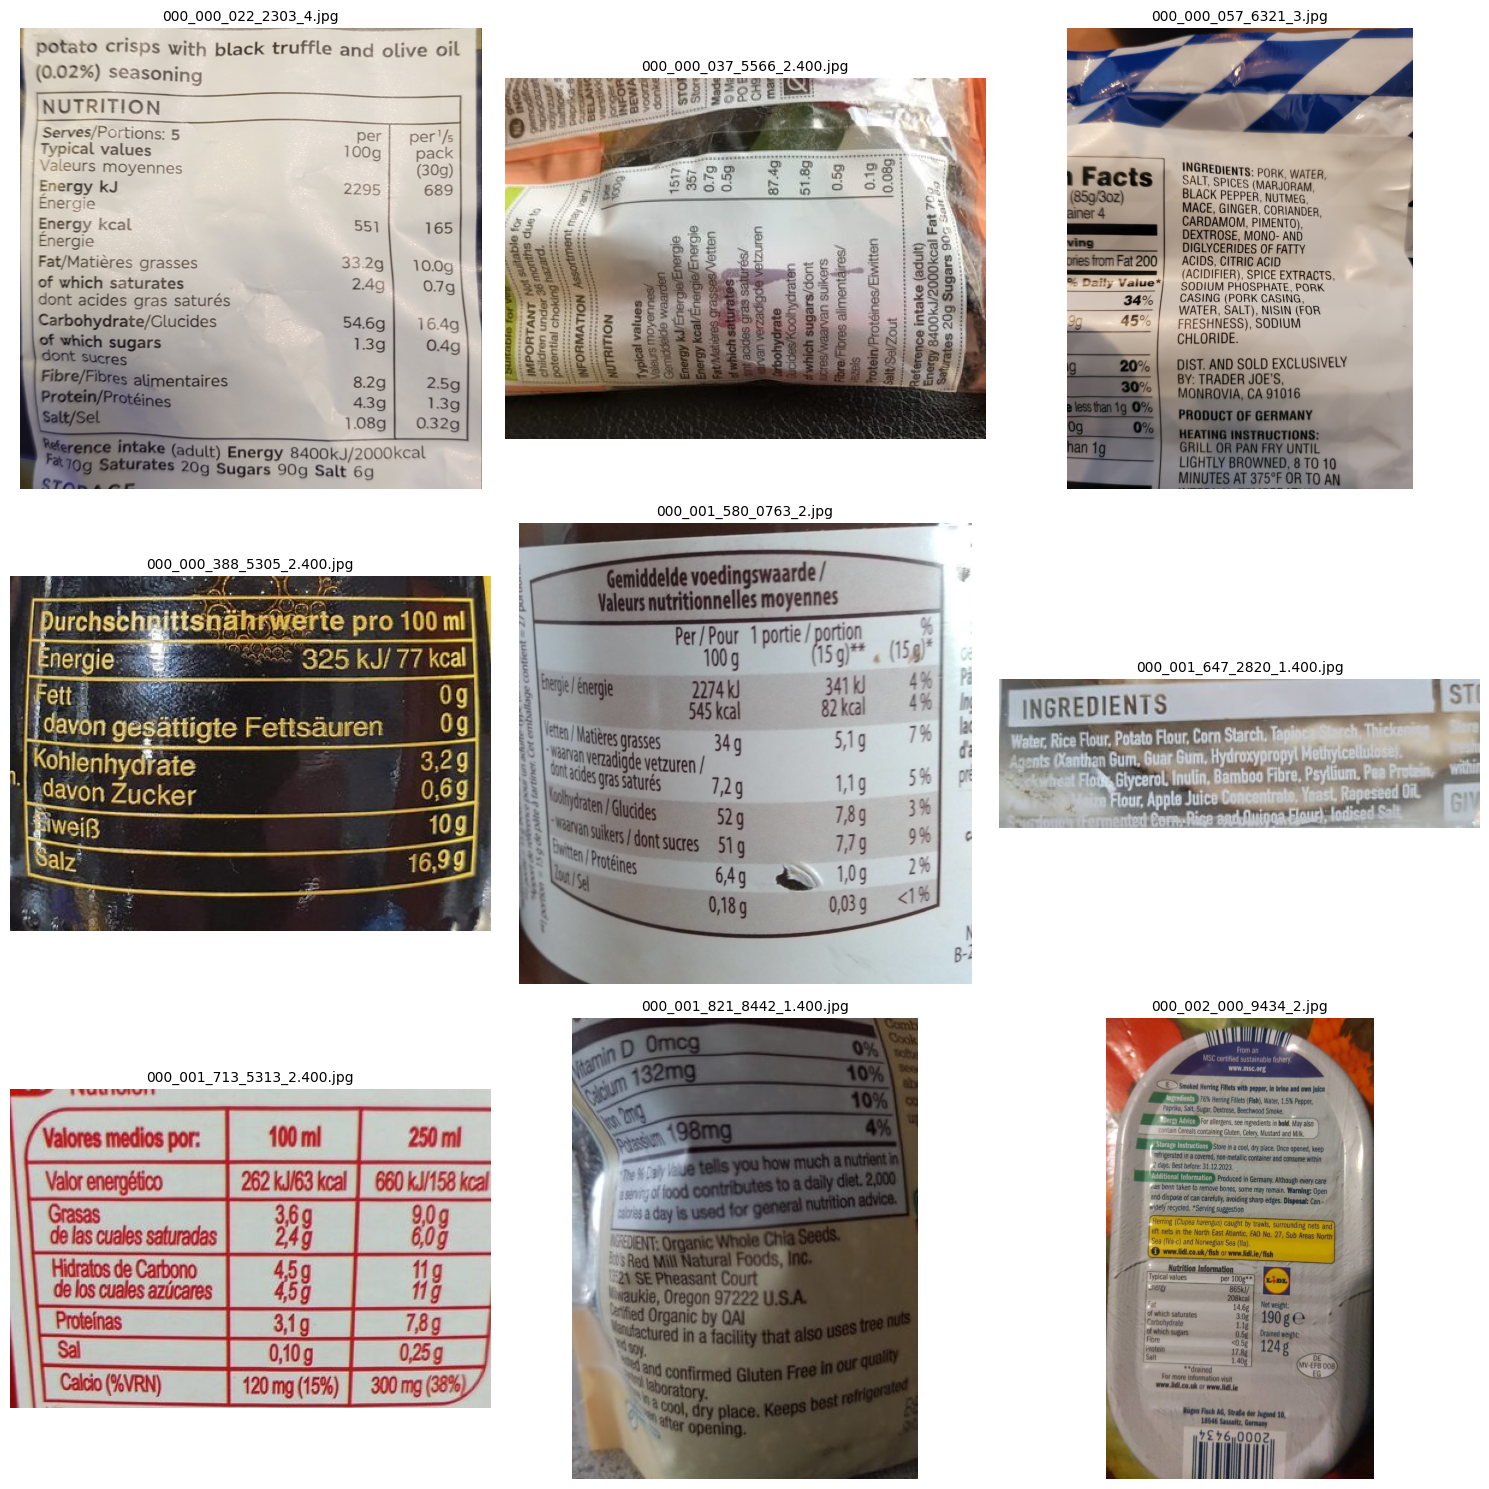

In [8]:
# Set the path to your images directory
image_dir = r"D:\Y4 Research\datasets\ingredient & nutrition Images\raw"

# Get all PNG files from the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

print(f"Found {len(image_files)} PNG images in the directory")

# Display basic information about the dataset
if image_files:
    print(f"\nFirst few image names:")
    for img_name in image_files[:5]:
        print(f"  - {img_name}")

# Function to display a grid of images
def display_images(image_dir, image_files, num_images=9, figsize=(15, 15)):
    """
    Display a grid of images from the dataset
    
    Parameters:
    - image_dir: directory path
    - image_files: list of image filenames
    - num_images: number of images to display (default: 9)
    - figsize: figure size for the plot
    """
    num_images = min(num_images, len(image_files))
    cols = 3
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for i in range(num_images):
        img_path = os.path.join(image_dir, image_files[i])
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(image_files[i], fontsize=10)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first 9 images
if image_files:
    display_images(image_dir, image_files, num_images=9)

In [4]:
from pathlib import Path

def resize_with_aspect_ratio(img, target_size=1024):
    h, w = img.shape[:2]

    # scaling factor to fit largest side
    scale = target_size / max(h, w)

    new_w = int(w * scale)
    new_h = int(h * scale)

    resized = cv2.resize(img, (new_w, new_h))

    # create padded square canvas (black padding)
    canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # paste resized image onto canvas (top-left)
    canvas[0:new_h, 0:new_w] = resized

    return canvas


# Input and Output directories
input_dir = r"D:\Y4 Research\datasets\food test"
output_dir = r"D:\Y4 Research\datasets\food test\normalized"

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all PNG images in input directory
for filename in os.listdir(input_dir):

    # Only process PNG files
    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    img_path = os.path.join(input_dir, filename)

    img = cv2.imread(img_path)
    if img is None:
        print(f"Skipping (cannot read): {filename}")
        continue

    # Normalize image (resize + pad)
    out = resize_with_aspect_ratio(img, 1024)

    # Remove original extension and add .png
    base_name = Path(filename).stem
    save_path = os.path.join(output_dir, base_name + ".png")

    # Save as PNG
    cv2.imwrite(save_path, out)

    print(f"Processed: {filename}")

print("All PNG images processed successfully!")

Processed: dark choc 2.png
Processed: dark choc1.png
Processed: ketchup.png
Processed: marmite.png
Skipping non-PNG file: normalized
Processed: potato chips.png
Processed: Tofu.png
All PNG images processed successfully!


In [5]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    corrected = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return corrected


# ------------------------------
# Shadow removal (morphological method)
# ------------------------------
def remove_shadows(img):
    rgb_planes = cv2.split(img)
    result_planes = []

    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((25,25), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 25)

        diff = 255 - cv2.absdiff(plane, bg_img)

        norm = cv2.normalize(diff, None, alpha=0, beta=255,
                             norm_type=cv2.NORM_MINMAX)
        result_planes.append(norm)

    result = cv2.merge(result_planes)
    return result


# ------------------------------
# Paths
# ------------------------------
input_dir = r"D:\Y4 Research\datasets\food test\normalized"
output_dir = r"D:\Y4 Research\datasets\food test\illumination_corrected"

os.makedirs(output_dir, exist_ok=True)


# ------------------------------
# Processing loop
# ------------------------------
for filename in os.listdir(input_dir):

    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Cannot read: {filename}")
        continue

    # Apply illumination correction
    img_clahe = apply_clahe(img)
    img_final = remove_shadows(img_clahe)

    # Save output PNG
    base = Path(filename).stem
    save_path = os.path.join(output_dir, base + ".png")
    cv2.imwrite(save_path, img_final)

    print(f"Processed: {filename}")


print("All illumination-corrected images saved successfully!")

Processed: dark choc 2.png
Processed: dark choc1.png
Processed: ketchup.png
Processed: marmite.png
Processed: potato chips.png
Processed: Tofu.png
All illumination-corrected images saved successfully!


In [6]:
def denoise_image(img):

    # 1. Median blur (removes salt & pepper noise)
    median = cv2.medianBlur(img, 3)

    # 2. Bilateral filter (smooth noise + preserve edges)
    bilateral = cv2.bilateralFilter(median, d=9, sigmaColor=75, sigmaSpace=75)

    return bilateral


# ---------------------------------------
# Paths
# ---------------------------------------
input_dir = r"D:\Y4 Research\datasets\food test\illumination_corrected"
output_dir = r"D:\Y4 Research\datasets\food test\Denoised"

os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------
# Processing Loop
# ---------------------------------------
for filename in os.listdir(input_dir):

    # Only PNG images
    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    file_path = os.path.join(input_dir, filename)
    img = cv2.imread(file_path)

    if img is None:
        print(f"Cannot read file: {filename}")
        continue

    # Apply noise removal
    clean = denoise_image(img)

    # Save image
    base_name = Path(filename).stem
    save_path = os.path.join(output_dir, base_name + ".png")
    cv2.imwrite(save_path, clean)

    print(f"Processed: {filename}")

print("All denoised images saved successfully!")

Processed: dark choc 2.png
Processed: dark choc1.png
Processed: ketchup.png
Processed: marmite.png
Processed: potato chips.png
Processed: Tofu.png
All denoised images saved successfully!


In [7]:
# 1. Sharpening (Unsharp Mask)
# ---------------------------------------
def sharpen_image(img):
    gaussian = cv2.GaussianBlur(img, (0, 0), sigmaX=2)
    sharp = cv2.addWeighted(img, 1.5, gaussian, -0.5, 0)
    return sharp

# ---------------------------------------
# 2. CLAHE for contrast improvement
# ---------------------------------------
def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)

    enhanced = cv2.merge((l2, a, b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    return enhanced

# ---------------------------------------
# 3. Adaptive threshold smoothing
# ---------------------------------------
def adaptive_smooth(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    smooth = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY,
                                   31, 10)
    
    # Convert back to 3-channel for VLM consistency
    smooth = cv2.cvtColor(smooth, cv2.COLOR_GRAY2BGR)
    return smooth

# ---------------------------------------
# Complete enhancement pipeline
# ---------------------------------------
def final_text_enhancement(img):
    step1 = enhance_contrast(img)
    step2 = sharpen_image(step1)
    step3 = adaptive_smooth(step2)
    return step3


# ---------------------------------------
# Paths
# ---------------------------------------
input_dir = r"D:\Y4 Research\datasets\food test\Denoised"
output_dir = r"D:\Y4 Research\datasets\food test\Enhanced"

os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------
# Processing loop
# ---------------------------------------
for filename in os.listdir(input_dir):

    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Cannot read: {filename}")
        continue

    enhanced = final_text_enhancement(img)

    base = Path(filename).stem
    save_path = os.path.join(output_dir, base + ".png")
    cv2.imwrite(save_path, enhanced)

    print(f"Enhanced: {filename}")

print("All images enhanced successfully!")

Enhanced: dark choc 2.png
Enhanced: dark choc1.png
Enhanced: ketchup.png
Enhanced: marmite.png
Enhanced: potato chips.png
Enhanced: Tofu.png
All images enhanced successfully!
